In [1]:
import sys
if "../" not in sys.path: sys.path.append("../")

from os import path

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from scipy import ndimage as ndi
from scipy import stats

import seaborn as sns
# sns.set_palette("deep")
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.facecolor':'white'})
plt.rcParams["figure.facecolor"] = "white"

from tqdm.notebook import tqdm

%matplotlib inline

%load_ext autoreload
%autoreload 2
""
from analysis_helpers import *
from eye_plotting import AREA_ORDERING, AREA_ABBREV
from experiment.cre_line import match_cre_line, CRE_ORDERING, CRE_COLORS
from saccade_config import *

In [28]:
IS_SPONTANEOUS_ONLY = False
cells = load_additional_data(LOADED_CLASSIFIED_CELLS_SPONTANEOUS_CSV if IS_SPONTANEOUS_ONLY else LOADED_CLASSIFIED_CELLS_CSV, in_data_dir=False, index_col=0)
# cells = load_additional_data(f"{DATA_DIR}/classified_cells_v1/cells.csv", in_data_dir=False, index_col=0) # Original data

SAVE_FILE_PREFIX = "spontaneous/" if IS_SPONTANEOUS_ONLY else ""

BUNCH_ALL_SR = False

CRE_PLOT_KEY = "cre_abbrev"
cells[CRE_PLOT_KEY] = cells[CRE_PLOT_KEY].apply(lambda x: x.replace(" ", "")) # backwards compatability; make "Cux2; Ai93" -> "Cux2;Ai93"
print(f"There are {len(cells):,} total cells.")
cells["session_indices_str"] = cells["session_indices"]
cells["session_indices"] = cells["session_indices"].apply(eval)
add_cell_df_columns(cells)
cells.head()

There are 32,442 total cells.


,cre_line,cre_abbrev,depth,targeted_structure,container_id,session_indices,response_classification,p_value,n_left,n_right,...,depth_trunc,cortical_layer,is_sr,is_sr_ds,is_sr_miura,is_sr_ds_miura,preferred_direction,preferred_direction_miura,sr_label,sr_label_miura
specimen_id,,,,,,,,,,,,,,,,,,,,,
589170196,Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f),Cux2;Ai93,175.0,VISp,511510718.0,"((510174759, 11), (510345479, 67), (510514474,...",0.0,0.148500,25.0,36.0,...,100,2/3,False,False,False,False,0,NaN,No response,No response
517424547,Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f),Cux2;Ai93,175.0,VISp,511510718.0,"((510174759, 109), (510345479, 68), (510514474...",0.0,0.849025,25.0,36.0,...,100,2/3,False,False,False,False,0,NaN,No response,No response
589170394,Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f),Cux2;Ai93,175.0,VISp,511510718.0,"((510174759, 27), (510345479, 205), (510514474...",0.0,0.994925,25.0,36.0,...,100,2/3,False,False,True,True,0,NaN,No response,No response
589170745,Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f),Cux2;Ai93,175.0,VISp,511510718.0,"((510174759, 6), (510345479, 206), (510514474,...",0.0,0.018600,25.0,36.0,...,100,2/3,False,False,False,False,0,NaN,No response,No response
589170856,Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f),Cux2;Ai93,175.0,VISp,511510718.0,"((510174759, 9), (510345479, 22), (510514474, 9))",0.0,0.231125,25.0,36.0,...,100,2/3,False,False,True,True,0,NaN,No response,No response


In [15]:
k = 3
n = len(cells)
cells = cells[(cells.n_left >= k) & (cells.n_right >= k)]

print(f"{len(cells)}/{n}")

32504/32504


In [29]:
metrics, cells_and_metrics = load_metrics(cells=cells)
cells_and_metrics.head()

/opt/anaconda3/envs/mindscope/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (4,8,12,16,20,32,53,69) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


21,612/32,442 cells have associated metrics


,cre_line,cre_abbrev,depth,targeted_structure,container_id,session_indices,response_classification,p_value,n_left,n_right,...,run_stat_dg,responsive_rundg,run_corr_mean,run_corr_A_lw,run_corr_B_lw,run_corr_C_lw,responsive_run,dg_all_RidgeRegress_CC,cluster_id,DSI_pref_tf
589170196,Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f),Cux2;Ai93,175.0,VISp,511510718.0,"((510174759, 11), (510345479, 67), (510514474,...",0.0,0.148500,25.0,36.0,...,NaN,False,0.042226,0.071127,0.042226,0.030272,True,0.060153,12.0,0.527993
517424547,Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f),Cux2;Ai93,175.0,VISp,511510718.0,"((510174759, 109), (510345479, 68), (510514474...",0.0,0.849025,25.0,36.0,...,NaN,False,0.055001,-0.002882,0.055001,0.023352,True,0.190018,14.0,1.000000
589170394,Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f),Cux2;Ai93,175.0,VISp,511510718.0,"((510174759, 27), (510345479, 205), (510514474...",0.0,0.994925,25.0,36.0,...,NaN,False,0.010461,-0.016332,0.010461,0.007804,True,0.007472,8.0,0.878755
589170745,Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f),Cux2;Ai93,175.0,VISp,511510718.0,"((510174759, 6), (510345479, 206), (510514474,...",0.0,0.018600,25.0,36.0,...,NaN,False,-0.018242,0.014539,-0.018242,0.025295,True,0.138445,12.0,0.796653
589170856,Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f),Cux2;Ai93,175.0,VISp,511510718.0,"((510174759, 9), (510345479, 22), (510514474, 9))",0.0,0.231125,25.0,36.0,...,NaN,False,0.159348,-0.005516,0.159348,-0.014270,True,0.238036,8.0,0.639498


In [17]:
CLUSTER_IDS = sorted(int(x) for x in cells_and_metrics["cluster_id"].dropna().unique())
CLUSTER_ID_TO_LABEL = [
    x.replace("-", "–") # slightly longer dash
    for x in (
        "None", "DG", "SG", "DG-SG", "NS", "DG-NS", "SG-NS", "DG-SG-NS",
        "NM", "DG-NM", "SG-NM", "DG-SG-NM", "NS-NM", "DG-NS-NM", "SG-NS-NM", "DG-SG-NS-NM"
    )
]
CLUSTER_ID_LABELS = [CLUSTER_ID_TO_LABEL[x] for x in CLUSTER_IDS]

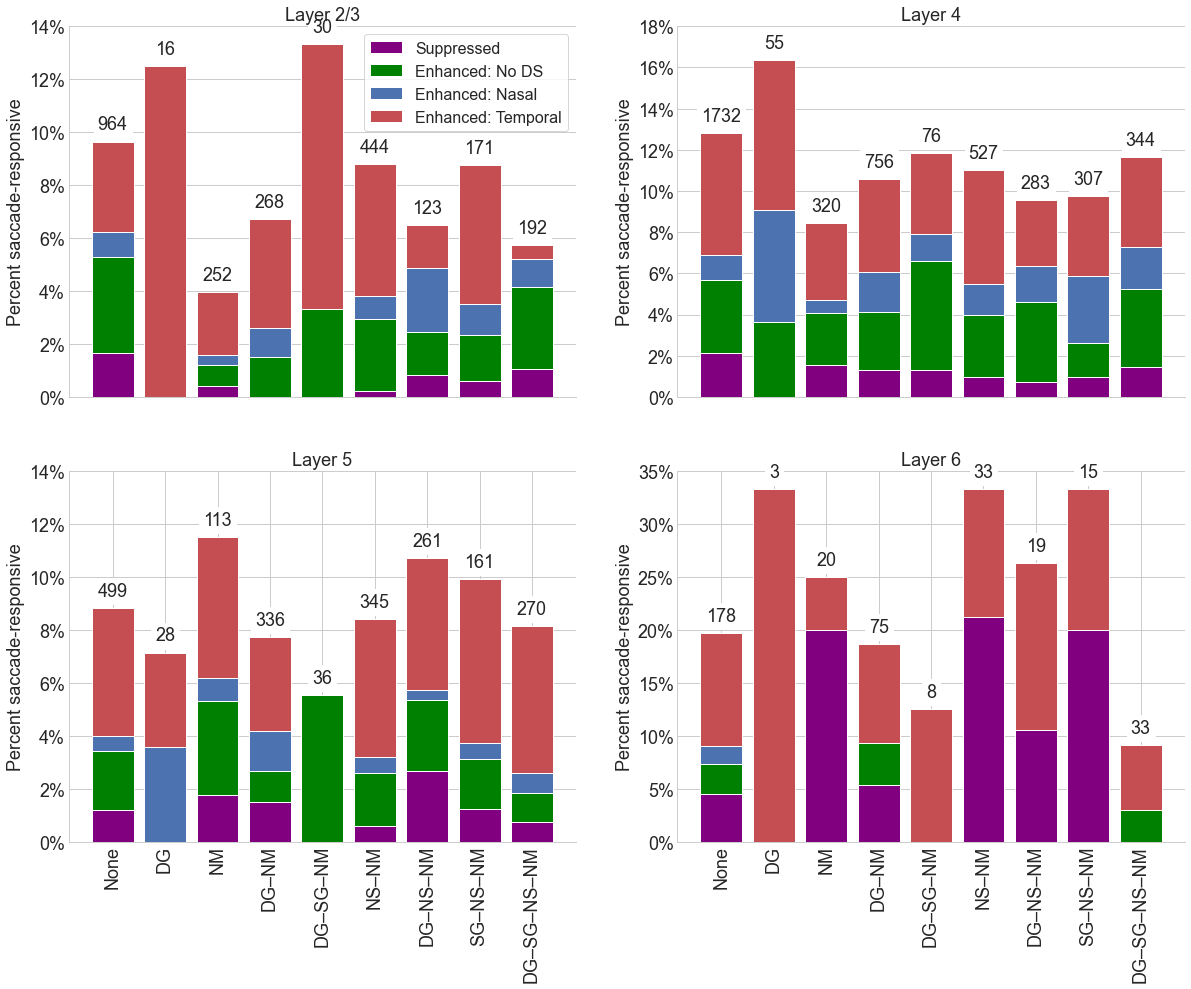

In [18]:
with plt.style.context("seaborn-whitegrid"):
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 15), facecolor="white")
    axs = axs.flatten()

    for i, layer in enumerate(sorted(cells_and_metrics["cortical_layer"].dropna().unique())):
        # fig, ax = plt.subplots(figsize=(15, 8), facecolor="white")
        ax = axs[i]
        bottom = None
        df = cells_and_metrics[cells_and_metrics["cortical_layer"] == layer].groupby("cluster_id")["sr_label"].value_counts(normalize=True)
        areas = [AREA_ABBREV[area] for area in AREA_ORDERING]

        for sr_label, color in SR_LABELS:
            if sr_label == "No response": continue
            heights = []
            for cluster_id in CLUSTER_IDS:
                heights.append(df[cluster_id].get(sr_label, 0) if cluster_id in df else 0)
            ax.bar(CLUSTER_ID_LABELS, heights, bottom=bottom, label=sr_label, color=color)
            bottom = heights if bottom is None else bottom + np.array(heights)

        if i == 0:
            ax.legend(fontsize=16, frameon=True)
        plt.setp(ax.get_xticklabels(), fontsize=18, rotation=90)
        plt.setp(ax.get_yticklabels(), fontsize=18)
        ax.set_xlabel("")
        # yticks = [0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5]
        # ax.set_yticks([tick/100 for tick in yticks])
        ax.set_yticks(ax.get_yticks())
        yticks = ax.get_yticks()
        ax.set_yticklabels([f"{tick*100:.0f}%" for tick in yticks], fontsize=18)
        ax.set_ylabel("Percent saccade-responsive", fontsize=18)

        if i < 2:
            ax.set_xticks([])

        # bar_labels = [f"{((cells_and_metrics['cluster_id'] == cluster_id) & (cells_and_metrics['is_sr'])).sum()}\n({(cells_and_metrics['cluster_id'] == cluster_id).sum()})" for cluster_id in cluster_ids]
        # bar_labels = [f"{((cells_and_metrics['cluster_id'] == cluster_id) & (cells_and_metrics['is_sr'])).sum()}/{(cells_and_metrics['cluster_id'] == cluster_id).sum()}" for cluster_id in cluster_ids]
        bar_labels = [f"{(cells_and_metrics['cluster_id'] == cluster_id).sum()}" for cluster_id in CLUSTER_IDS]
        bar_labels = [f"{((cells_and_metrics['cluster_id'] == cluster_id) & (cells_and_metrics['cortical_layer'] == layer)).sum()}" for cluster_id in CLUSTER_IDS]
        ax.bar_label(ax.containers[-1], labels=bar_labels, padding=8, fontsize=18, backgroundcolor="w")
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_title(f"Layer {layer}", fontsize=18)
    # savefig(fig, f"{SAVE_FILE_PREFIX}cluster_ids.png")

[DSI_pref_tf] Not SR vs. No DS: p = 0.0113
[DSI_pref_tf] Not SR vs. N: p = 0.9407
[DSI_pref_tf] Not SR vs. T: p = 0.1161
[DSI_pref_tf] No DS vs. N: p = 0.1315
[DSI_pref_tf] No DS vs. T: p = 0.0553
[DSI_pref_tf] N vs. T: p = 0.8468


/opt/anaconda3/envs/mindscope/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


[g_dsi_dg] Not SR vs. No DS: p = 0.0257
[g_dsi_dg] Not SR vs. N: p = 0.4571
[g_dsi_dg] Not SR vs. T: p = 0.0661
[g_dsi_dg] No DS vs. N: p = 0.2489
[g_dsi_dg] No DS vs. T: p = 0.3810
[g_dsi_dg] N vs. T: p = 0.3865


/opt/anaconda3/envs/mindscope/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


[g_osi_dg] Not SR vs. No DS: p = 0.3038
[g_osi_dg] Not SR vs. N: p = 0.0023
[g_osi_dg] Not SR vs. T: p = 0.1217
[g_osi_dg] No DS vs. N: p = 0.0764
[g_osi_dg] No DS vs. T: p = 0.7450
[g_osi_dg] N vs. T: p = 0.0684


/opt/anaconda3/envs/mindscope/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


[lifetime_sparseness_ns] Not SR vs. No DS: p = 0.5708
[lifetime_sparseness_ns] Not SR vs. N: p = 0.0028
[lifetime_sparseness_ns] Not SR vs. T: p = 0.0611
[lifetime_sparseness_ns] No DS vs. N: p = 0.0206
[lifetime_sparseness_ns] No DS vs. T: p = 0.5309
[lifetime_sparseness_ns] N vs. T: p = 0.0136


/opt/anaconda3/envs/mindscope/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


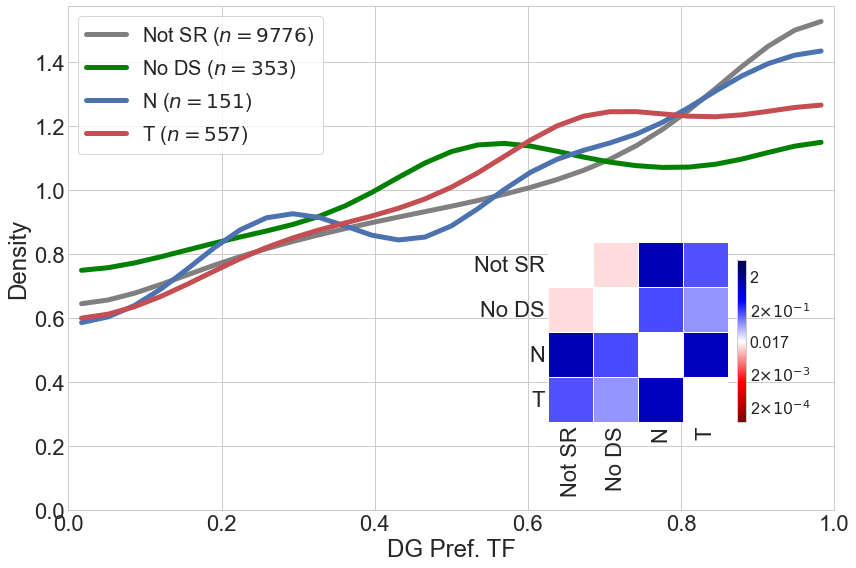

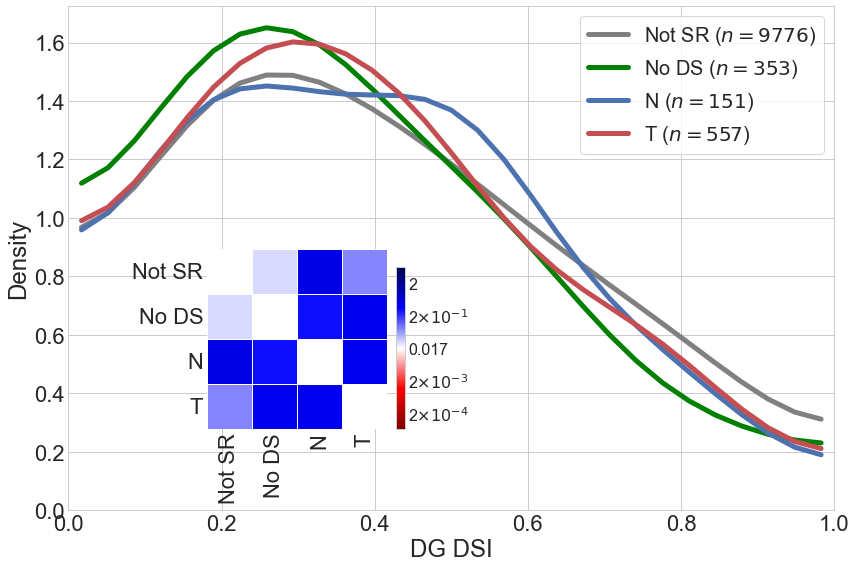

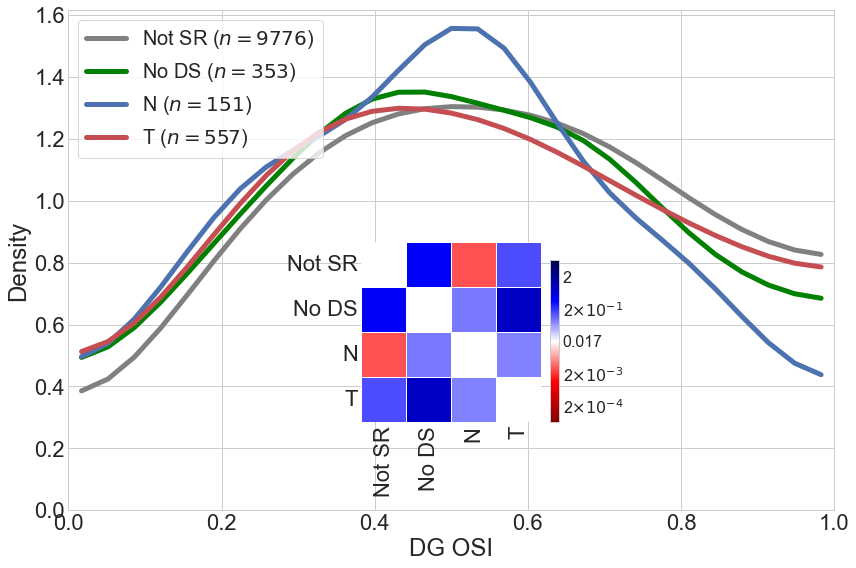

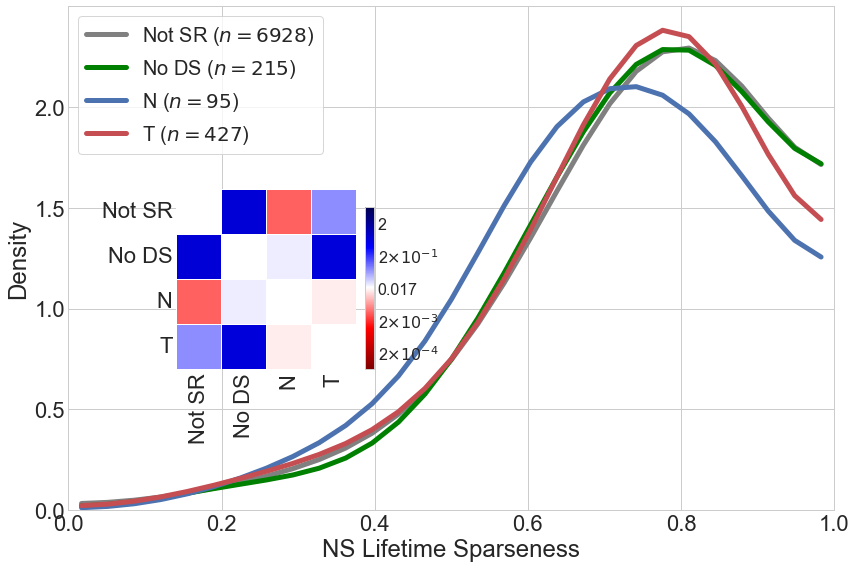

In [31]:
from mpl_toolkits.axes_grid.inset_locator import inset_axes

sr_label_abbrev = {
    "No response": "Not SR",
    "Enhanced: No DS": "No DS",
    "Enhanced: Nasal": "N",
    "Enhanced: Temporal": "T",
    "Suppressed": "Suppressed"
}

with plt.style.context("seaborn-whitegrid"):
    for metric, response_metric, plot_label, legend_loc, inset_loc in [
        ("DSI_pref_tf", "responsive_dg", "DG Pref. TF", "upper left", "lower right"),
        ("g_dsi_dg", "responsive_dg", "DG DSI", "upper right", (0.15, 0.15)),
        ("g_osi_dg", "responsive_dg", "DG OSI", "upper left", "lower center"),
        ("lifetime_sparseness_ns", "responsive_ns", "NS Lifetime Sparseness", "upper left", (0.11, 0.27, 0.5, 0.5))
        # ("image_selectivity_ns", "responsive_ns", "Image selectivity")
    ]:
        if response_metric is not None:
            has_response = (cells_and_metrics[response_metric] == True)
        else:
            has_response = ~cells_and_metrics[metric].isna()
        
        fig, ax = plt.subplots(figsize=(12, 8), facecolor="white")

        bins = np.linspace(0, 1, 30)
        bin_midpoints = (bins[1:] + bins[:-1]) / 2
        filter_window = 3
        dist_and_label = []

        if BUNCH_ALL_SR:
            for is_sr, color in ((False, "gray"), (True, "green")):
                dist = cells_and_metrics[metric].values[has_response & (cells_and_metrics["is_sr"] == is_sr)]
                label = "SR" if is_sr else "Not SR"
                dist_and_label.append((dist, label))
                hist, _ = np.histogram(dist, bins=bins, density=True)
                smoothed_curve = ndi.gaussian_filter1d(hist, filter_window)
                # ax.bar(bins[:-1], ndi.gaussian_filter1d(h, filter_window), width=np.mean(np.diff(bins)), color=color, alpha=0.2, lw=0)
                ax.plot(bin_midpoints, smoothed_curve, color=color, linewidth=5, label=f"{label} ($n = {len(dist)}$)")
        else:
            for label, color in SR_LABELS:
                dist = cells_and_metrics[metric].values[has_response & (cells_and_metrics["sr_label"] == label)]
                if label == "Suppressed" or len(dist) < 10: continue
                label = sr_label_abbrev[label]
                dist_and_label.append((dist, label))
                hist, _ = np.histogram(dist, bins=bins, density=True)
                smoothed_curve = ndi.gaussian_filter1d(hist, filter_window)
                # ax.bar(bins[:-1], ndi.gaussian_filter1d(h, filter_window), width=np.mean(np.diff(bins)), color=color, alpha=0.2, lw=0)
                ax.plot(bin_midpoints, smoothed_curve, color=color, linewidth=5, label=f"{label} ($n = {len(dist)}$)")
                # if label == "N" or label == "No DS":
                #     ax.hist(dist, bins=bins, density=False)

        legend = ax.legend(fontsize=20, frameon=True, loc=legend_loc)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, ax.get_ylim()[1])
        plt.setp((ax.get_xticklabels(), ax.get_yticklabels()), fontsize=22)
        ax.set_xlabel(plot_label, fontsize=24)
        ax.set_ylabel("Density", fontsize=24)
        
        # Inset the probability heatmap
        p_matrix = np.zeros((len(dist_and_label), len(dist_and_label)), dtype=float)
        
        for i in range(len(dist_and_label)):
            p_matrix[i,i] = np.nan
            for j in range(i+1, len(dist_and_label)):
                a, b = dist_and_label[i][0], dist_and_label[j][0]
                # p_val = stats.ttest_ind(a, b)[1]
                p_val = stats.kstest(a, b)[1]
                p_matrix[i,j] = p_matrix[j,i] = p_val
                print(f"[{metric}] {dist_and_label[i][1]} vs. {dist_and_label[j][1]}: p = {p_val:.4f}")

        if len(dist_and_label) > 2:
            if type(inset_loc) is str:
                kwargs = dict(loc=inset_loc, borderpad=8)
            else:
                kwargs = dict(loc="lower left", bbox_to_anchor=inset_loc, bbox_transform=ax.transAxes)
            
            ax_pmatrix = inset_axes(ax, width=3, height=2.5, **kwargs)
            heatmap_log_proba_plot(p_matrix, ticklabels=[x[1] for x in dist_and_label], ax=ax_pmatrix, is_inset=True, title="", ticklabelfontsize=22) # title=f"{plot_label}"
        else:
            # Display probability text
            p = p_matrix[0, 1]
            if p > 0.05:
                # text = "> 0.05"
                text = f"N.S. (p = {p:.2f})"
            elif p > 0.01:
                text = "p > 0.01"
            else:
                text = "p < 0.01"
            legend.set_title(text)
            legend.get_title().set_fontsize(26)
            legend.get_title().set_fontweight("bold")


        fig.tight_layout()
        # savefig(fig, f"{SAVE_FILE_PREFIX}metric_{metric}.png")
        # break

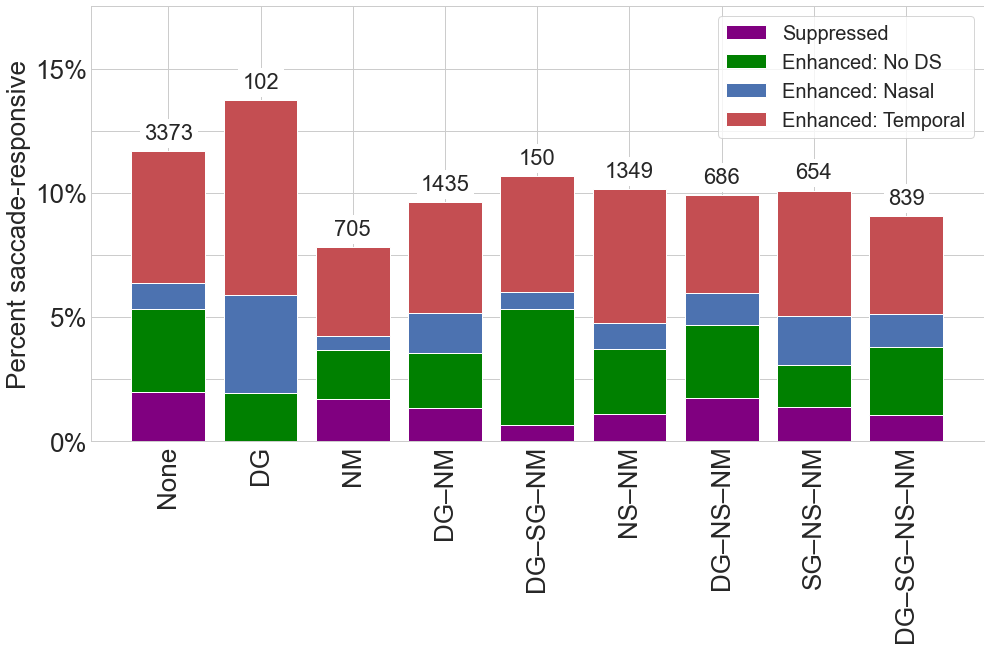

In [20]:
with plt.style.context("seaborn-whitegrid"):
    fig, ax = plt.subplots(figsize=(16, 8), facecolor="white")
    bottom = None
    areas = [AREA_ABBREV[area] for area in AREA_ORDERING]

    if BUNCH_ALL_SR:
        df = cells_and_metrics.groupby("cluster_id")["is_sr"].value_counts(normalize=True)
        for is_sr, color in ((False, "gray"), (True, "green")):
            label = "SR" if is_sr else "Not SR"
            heights = []
            for cluster_id in CLUSTER_IDS:
                heights.append(df[cluster_id].get(is_sr, 0) if cluster_id in df else 0)
            ax.bar(CLUSTER_ID_LABELS, heights, bottom=bottom, label=sr_label, color=color)
            bottom = heights if bottom is None else bottom + np.array(heights)
    else:
        df = cells_and_metrics.groupby("cluster_id")["sr_label"].value_counts(normalize=True)
        for sr_label, color in SR_LABELS:
            if sr_label == "No response": continue
            heights = []
            for cluster_id in CLUSTER_IDS:
                heights.append(df[cluster_id].get(sr_label, 0) if cluster_id in df else 0)
            ax.bar(CLUSTER_ID_LABELS, heights, bottom=bottom, label=sr_label, color=color)
            bottom = heights if bottom is None else bottom + np.array(heights)

    ax.legend(fontsize=20, frameon=True)
    plt.setp(ax.get_xticklabels(), fontsize=26, rotation=90)
    ax.set_xlabel("")
    yticks = [0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5]
    ax.set_yticks([tick/100 for tick in yticks])
    ax.set_yticklabels([f"{tick:.0f}%" if tick == int(tick) else None for tick in yticks], fontsize=26)
    ax.set_ylabel("Percent saccade-responsive", fontsize=26)

    n_total_in_cluster = [(cells_and_metrics['cluster_id'] == cluster_id).sum() for cluster_id in CLUSTER_IDS]
    n_sr_in_cluster = [((cells_and_metrics['cluster_id'] == cluster_id) & (cells_and_metrics['is_sr'])).sum() for cluster_id in CLUSTER_IDS]
    # bar_labels = [f"{n_sr} / {n_tot}" for n_sr, n_tot in zip(n_sr_in_cluster, n_total_in_cluster)]
    bar_labels = [f"{n_tot}" for n_tot in n_total_in_cluster]
    ax.bar_label(ax.containers[-1], labels=bar_labels, padding=8, fontsize=22, backgroundcolor="w")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    # savefig(fig, f"{SAVE_FILE_PREFIX}cluster_ids.png")

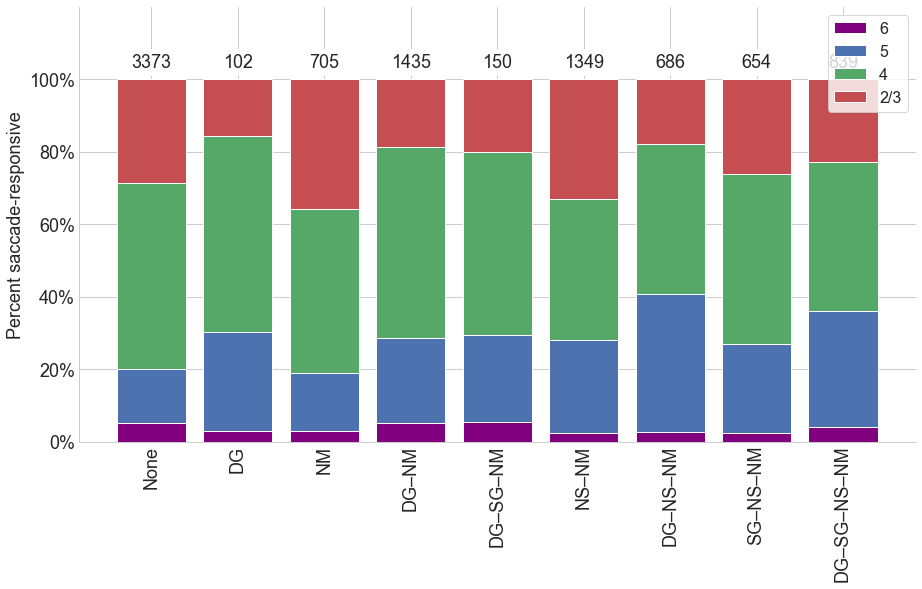

In [21]:
layer_and_color = [
    ("2/3", "r"),
    ("4", "g"),
    ("5", "b"),
    ("6", "purple")
]

with plt.style.context("seaborn-whitegrid"):
    fig, ax = plt.subplots(figsize=(15, 8), facecolor="white")
    bottom = None
    df = cells_and_metrics.groupby("cluster_id")["cortical_layer"].value_counts(normalize=True)
    areas = [AREA_ABBREV[area] for area in AREA_ORDERING]

    for layer, color in reversed(layer_and_color):
        heights = []
        for cluster_id in CLUSTER_IDS:
            heights.append(df[cluster_id][layer] if layer in df[cluster_id] else 0)
        ax.bar(CLUSTER_ID_LABELS, heights, bottom=bottom, label=layer, color=color)
        bottom = heights if bottom is None else bottom + np.array(heights)

    ax.legend(fontsize=16, frameon=True)
    plt.setp(ax.get_xticklabels(), fontsize=18, rotation=90)
    plt.setp(ax.get_yticklabels(), fontsize=18)
    ax.set_xlabel("")
    # yticks = [0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5]
    # ax.set_yticks([tick/100 for tick in yticks])
    ax.set_yticks(ax.get_yticks())
    yticks = [0, .2 , .4, .6, .8, 1]
    ax.set_yticks(yticks)
    ax.set_yticklabels([f"{tick*100:.0f}%" for tick in yticks], fontsize=18)
    ax.set_ylabel("Percent saccade-responsive", fontsize=18)

    if i < 2:
        ax.set_xticks([])

    # bar_labels = [f"{((cells_and_metrics['cluster_id'] == cluster_id) & (cells_and_metrics['is_sr'])).sum()}\n({(cells_and_metrics['cluster_id'] == cluster_id).sum()})" for cluster_id in cluster_ids]
    # bar_labels = [f"{((cells_and_metrics['cluster_id'] == cluster_id) & (cells_and_metrics['is_sr'])).sum()}/{(cells_and_metrics['cluster_id'] == cluster_id).sum()}" for cluster_id in cluster_ids]
    bar_labels = [f"{(cells_and_metrics['cluster_id'] == cluster_id).sum()}" for cluster_id in CLUSTER_IDS]
    ax.bar_label(ax.containers[-1], labels=bar_labels, padding=8, fontsize=18, backgroundcolor="w")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    # savefig(fig, f"{SAVE_FILE_PREFIX}cluster_ids.png")

cluster_id  is_sr
0.0         False    3023
            True      112
1.0         False      93
            True        6
Name: is_sr, dtype: int64


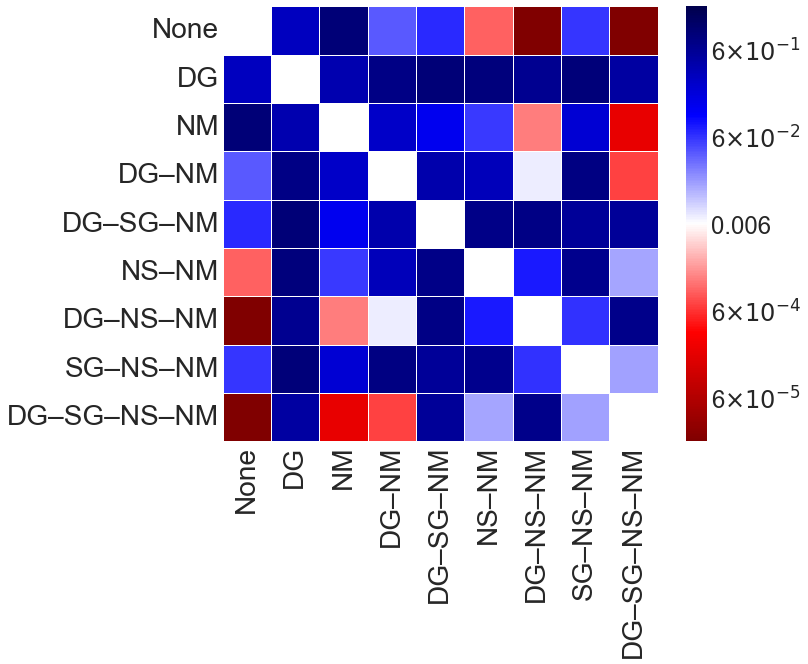

In [10]:
n = len(CLUSTER_IDS)
p_matrix = np.full((n, n), np.nan, dtype=float)
counts = cells_and_metrics.groupby("cluster_id")["is_sr"].value_counts()

print(counts.head(4))

for i in range(n):
    for j in range(i+1, n):
        observed = [
            [counts[CLUSTER_IDS[i]].get(True, 0), counts[CLUSTER_IDS[i]].get(False, 0)],
            [counts[CLUSTER_IDS[j]].get(True, 0), counts[CLUSTER_IDS[j]].get(False, 0)]
        ]
        p_val = stats.chi2_contingency(observed)[1]
        p_matrix[i,j] = p_val
        p_matrix[j,i] = p_val

with plt.style.context("seaborn-whitegrid"):
    fig, ax = heatmap_log_proba_plot(p_matrix, ticklabels=CLUSTER_ID_LABELS, title="", titlefontsize=28, ticklabelfontsize=28, cbartickfontsize=24, figsize=(10, 8))
    savefig(fig, f"{SAVE_FILE_PREFIX}cluster_ids_proba.png")

In [11]:
print(f"{(cells_and_metrics['responsive_dg'] == True).sum():,} out of {len(cells):,} cells in our dataset were responsive to drifting gratings.")
print(f"{(cells_and_metrics['responsive_ns'] == True).sum():,} out of {len(cells):,} cells in our dataset were responsive to natural scenes.")

9,565 out of 27,912 cells in our dataset were responsive to drifting gratings.
6,961 out of 27,912 cells in our dataset were responsive to natural scenes.


[pref_ori_dg] Not SR vs. No DS: p = 0.9536
[pref_ori_dg] Not SR vs. N: p = 0.9984
[pref_ori_dg] Not SR vs. T: p = 0.5599
[pref_ori_dg] No DS vs. N: p = 0.9999
[pref_ori_dg] No DS vs. T: p = 0.8467
[pref_ori_dg] N vs. T: p = 1.0000


/opt/anaconda3/envs/mindscope/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


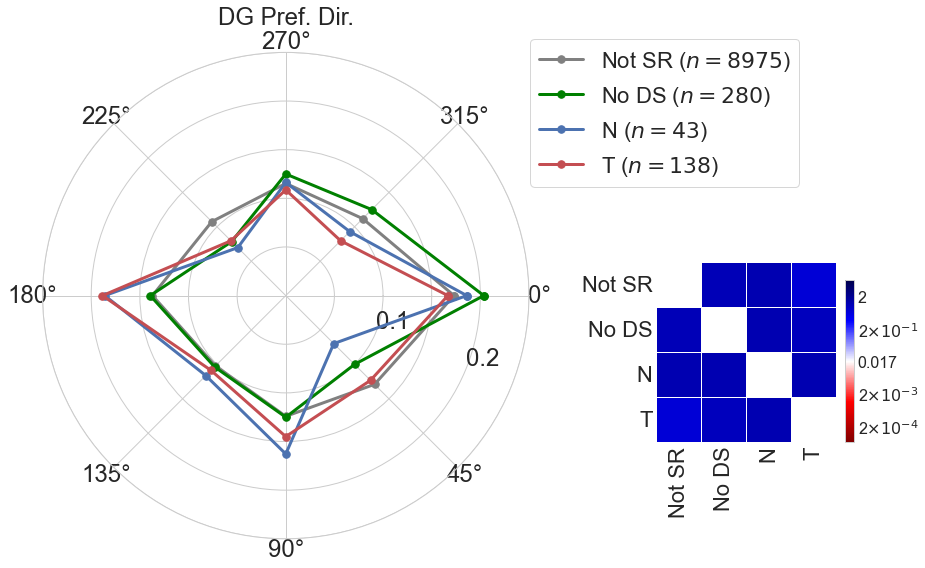

In [12]:
metric = "pref_ori_dg" # called preferred orientation but actually refers to direction of motion
has_response = cells_and_metrics["responsive_dg"] == True # == True needed because some may be NA
df = (
    cells_and_metrics[metric][has_response]
    .dropna()
    .groupby(cells_and_metrics["is_sr" if BUNCH_ALL_SR else "sr_label"])
    .value_counts(normalize=True)
    .rename("fraction")
)
angles = sorted(cells_and_metrics["pref_ori_dg"].dropna().unique()) + [360.0]
r = np.arange(0, 2, 0.05)
theta = 2 * np.pi * r

with plt.style.context("seaborn-whitegrid"):
    fig, ax = plt.subplots(figsize=(12, 8), facecolor="white", subplot_kw=dict(projection="polar"))
    ax.set_theta_direction(-1)
    dist_and_label = []

    if BUNCH_ALL_SR:
        for is_sr, color in ((False, "gray"), (True, "green")):
            label = "SR" if is_sr else "Not SR"
            r = [df[is_sr].get(angle % 360, 0) for angle in angles]
            dist = cells_and_metrics[metric][has_response & (cells_and_metrics["is_sr"] == is_sr)].dropna()
            dist_and_label.append((dist, label))
            ax.plot(np.radians(angles), r, color=color, marker=".", markersize=15, linewidth=3, label=f"{label} ($n = {len(dist)}$)")
    else:
        for label, color in SR_LABELS:
            r = [df[label].get(angle % 360, 0) if label in df else 0 for angle in angles]
            dist = cells_and_metrics[metric][has_response & (cells_and_metrics["sr_label"] == label)].dropna()
            if label == "Suppressed" or len(dist) < 10: continue
            label = SR_LABELS_ABBREV[label]
            dist_and_label.append((dist, label))
            ax.plot(np.radians(angles), r, color=color, marker=".", markersize=15, linewidth=3, label=f"{label} ($n = {len(dist)}$)")

    ax.set_rmax(0.25)
    ax.set_rticks([0.05, 0.10, 0.15, 0.20, 0.25])  # Less radial ticks
    ax.set_yticklabels([None, 0.10, None, 0.20, None])  # Less radial ticks
    ax.set_rlabel_position(22.5)  # Move radial labels away from plotted line
    plt.setp((ax.get_xticklabels(), ax.get_yticklabels()), fontsize=24)
    ax.grid(True)
    ax.set_title("DG Pref. Dir.", fontsize=24)
    legend = ax.legend(frameon=True, fontsize=22, loc="upper left", bbox_to_anchor=(0.98, 1.05))

    p_matrix = np.zeros((len(dist_and_label), len(dist_and_label)), dtype=float)
            
    for i in range(len(dist_and_label)):
        p_matrix[i,i] = np.nan
        for j in range(i+1, len(dist_and_label)):
            a, b = dist_and_label[i][0], dist_and_label[j][0]
            # p_val = stats.ttest_ind(a, b)[1]
            p_val = stats.kstest(a, b)[1]
            p_matrix[i,j] = p_matrix[j,i] = p_val
            print(f"[{metric}] {dist_and_label[i][1]} vs. {dist_and_label[j][1]}: p = {p_val:.4f}")

    if len(dist_and_label) > 2:
        ax_pmatrix = inset_axes(ax, width=2.5, height=3, loc="lower left", bbox_to_anchor=(1.25, 0.15, 0.5, 0.5), bbox_transform=ax.transAxes)
        heatmap_log_proba_plot(p_matrix, ticklabels=[x[1] for x in dist_and_label], title="", ticklabelfontsize=22, ax=ax_pmatrix, is_inset=True)
    else:
        # Display probability text
        p = p_matrix[0, 1]
        if p > 0.05:
            # text = "> 0.05"
            text = f"N.S. (p = {p:.2f})"
        elif p > 0.01:
            text = "p > 0.01"
        else:
            text = "p < 0.01"
        legend.set_title(text)
        legend.get_title().set_fontsize(26)
        legend.get_title().set_fontweight("bold")

    fig.tight_layout()
    savefig(fig, f"{SAVE_FILE_PREFIX}metric_pref_direction_dg_polar.png")

    # fig, ax = plt.subplots(figsize=(12, 8), facecolor="white")
    # sns.barplot(data=df.reset_index(), x=metric, y="fraction", hue="sr_label", palette={k: v for (k,v) in SR_LABELS}, hue_order=[x[0] for x in SR_LABELS])
    # ax.set_xticklabels([f"{float(x.get_text()):.0f}°" for x in ax.get_xticklabels()], fontsize=18)
    # plt.setp(ax.get_yticklabels(), fontsize=16)
    # ax.set_xlabel("")
    # ax.set_ylabel("Density", fontsize=16)
    # ax.legend(fontsize=16, frameon=True)

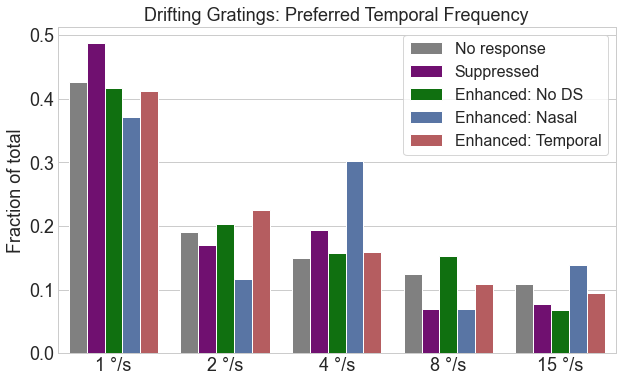

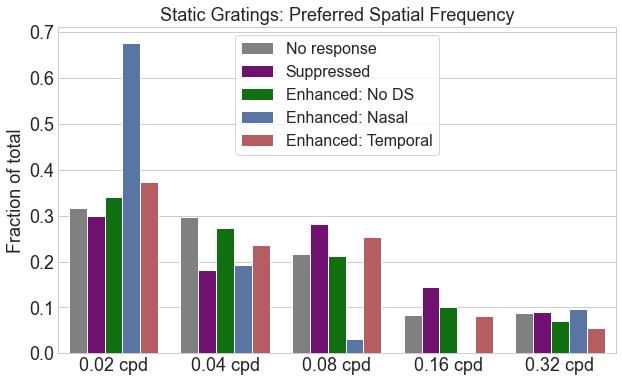

In [13]:
for metric, resp_metric, title in (
    ("pref_tf_dg", "responsive_dg", "Drifting Gratings: Preferred Temporal Frequency"),
    ("pref_sf_sg", "responsive_sg", "Static Gratings: Preferred Spatial Frequency")
):
    y = "fraction"
    df = (
        cells_and_metrics[cells_and_metrics["responsive_dg"] == True][metric]
        .dropna()
        .groupby(cells_and_metrics["sr_label"])
        .value_counts(normalize=True)
        .rename(y).reset_index()
    )

    # Get rid of suppressed cells
    with plt.style.context("seaborn-whitegrid"):
        fig, ax = plt.subplots(figsize=(10, 6), facecolor="white")
        sns.barplot(data=df, ax=ax, x=metric, y=y, hue="sr_label", palette={k: v for (k,v) in SR_LABELS}, hue_order=[x[0] for x in SR_LABELS])

        if "tf" in metric:
            ax.set_xticklabels([f"{float(x.get_text()):.0f} °/s" for x in ax.get_xticklabels()], fontsize=18)
        elif "sf" in metric:
            ax.set_xticklabels([f"{float(x.get_text()):.2f} cpd" for x in ax.get_xticklabels()], fontsize=18)

        plt.setp(ax.get_yticklabels(), fontsize=18)
        ax.set_xlabel("")
        ax.set_ylabel("Fraction of total", fontsize=18)
        ax.set_title(title, fontsize=18)
        ax.legend(fontsize=16, frameon=True)
        # TODO: superimposed trace